In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [11]:
web_info_df = pd.read_excel("/Users/ljohnson/repos/livjab/spoofmail/website_privacy.xlsx", sheet_name="Sheet1")
web_info_df.head()

,Country_Rank,Website,Trustworthiness,Avg_Daily_Visitors,Child_Safety,Avg_Daily_Pageviews,Privacy,Traffic_Rank,Daily_Pageviews,Daily_Pageviews_per_user_percentage,Location,Hosted_by,Registrant,Registrar,country,Privacy_policy
0,1,www.google.com,Excellent,518 108 189,Excellent,4 186 314 171,Excellent,1,8.448960,33.9,United States,Google Inc.,DNS Admin (Google Inc.),MARKMONITOR INC.,United States,"Privacy Policy Last modified: December 18, 201..."
1,2,www.youtube.com,Excellent,506 457 282,Excellent,2 679 159 025,Excellent,2,5.934720,3.8,United States,Google Inc.,DNS Admin (Google Inc.),MARKMONITOR INC.,United States,"Last modified: June 24, 2013 (view archived ve..."
2,3,www.facebook.com,Excellent,270 071 255,Good,1 082 985 733,Excellent,3,2.046720,-8.2,Ireland,Facebook,"Domain Administrator (Facebook, Inc.)",MARKMONITOR INC.,United States,Data Policy\nThis policy describes the informa...
3,4,www.reddit.com,Excellent,60 614 015,Excellent,649 176 107,Excellent,9,1.390080,0.8,United States,Fastly,Domain Administrator (Reddit Inc),GANDI SAS,United States,"Reddit Privacy Policy\nEffective June 8, 2018...."
4,5,www.amazon.com,Excellent,48 820 414,Excellent,399 350 988,Excellent,11,0.770688,-1.5,United States,Amazon Technologies Inc.,"Hostmaster, Amazon Legal Dept. (Amazon Technol...",MARKMONITOR INC.,United States,Amazon Privacy Notice\n\nLast updated: August ...


## Tokenize and visualize Privacy Policy Data

In [12]:
import re

def tokenizer(text):
    sample = re.sub(r'[^a-zA-Z ^0-9]', '', text)
    tokens = sample.lower().split()
    
    return tokens

In [13]:
web_info_df['tokens'] = web_info_df['Privacy_policy'].apply(tokenizer)
web_info_df['tokens'].head()

0    [privacy, policy, last, modified, december, 18...
1    [last, modified, june, 24, 2013, view, archive...
2    [data, policythis, policy, describes, the, inf...
3    [reddit, privacy, policyeffective, june, 8, 20...
4    [amazon, privacy, noticelast, updated, august,...
Name: tokens, dtype: object

In [14]:
from collections import Counter

word_counts = Counter()

web_info_df['tokens'].apply(lambda x: word_counts.update(x))

word_counts.most_common(10)

[('to', 6123),
 ('and', 5833),
 ('the', 4952),
 ('you', 4818),
 ('your', 4012),
 ('or', 3710),
 ('information', 3520),
 ('of', 3356),
 ('we', 3235),
 ('our', 2437)]

In [15]:
def count(docs):

        word_counts = Counter()
        appears_in = Counter()
        
        total_docs = len(docs)

        for doc in docs:
            word_counts.update(doc)
            appears_in.update(set(doc))

        temp = zip(word_counts.keys(), word_counts.values())
        
        wc = pd.DataFrame(temp, columns = ['word', 'count'])

        wc['rank'] = wc['count'].rank(method='first', ascending=False)
        total = wc['count'].sum()

        wc['pct_total'] = wc['count'].apply(lambda x: x / total)
        
        wc = wc.sort_values(by='rank')
        wc['cul_pct_total'] = wc['pct_total'].cumsum()

        t2 = zip(appears_in.keys(), appears_in.values())
        ac = pd.DataFrame(t2, columns=['word', 'appears_in'])
        wc = ac.merge(wc, on='word')

        wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x / total_docs)
        
        return wc.sort_values(by='rank')

In [16]:
wc = count(web_info_df['tokens'])
wc.head()

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
632,to,49,6123,1.0,0.037780,0.037780,1.000000
221,and,49,5833,2.0,0.035990,0.073770,1.000000
309,the,49,4952,3.0,0.030555,0.104325,1.000000
112,you,48,4818,4.0,0.029728,0.134052,0.979592
92,your,48,4012,5.0,0.024755,0.158807,0.979592


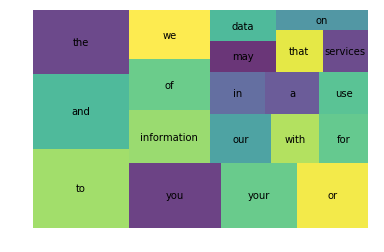

In [17]:
import squarify

wc_top20 = wc[wc['rank'] <= 20]
squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

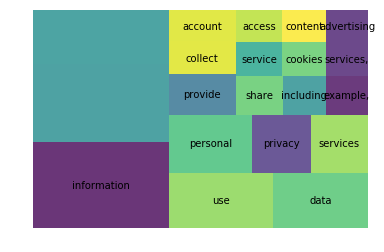

In [18]:
# omitting stop words
import spacy
from spacy.tokenizer import Tokenizer

import en_core_web_sm
nlp = en_core_web_sm.load()

STOP_WORDS = nlp.Defaults.stop_words.union(['\n', '\n \n', '\n\n'])

# Tokenizer
tokenizer = Tokenizer(nlp.vocab)
tokens = []

""" Update those tokens """
for doc in tokenizer.pipe(web_info_df['Privacy_policy'], batch_size=500):
    doc_tokens = []
    for token in doc:
        if (token.is_stop == False) and (token.is_punct == False):
            doc_tokens.append(token.text.lower())
    tokens.append(doc_tokens)        
    
web_info_df['tokens'] = tokens
wc = count(web_info_df['tokens'])

wc_top20 = wc[wc['rank'] <= 20]

squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

In [19]:
wc_top20

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
256,information,49,3172,1.0,0.034666,0.034666,1.000000
979,\n,47,2929,2.0,0.032011,0.066677,0.959184
970,\n\n,45,1975,3.0,0.021584,0.088261,0.918367
112,use,49,1569,4.0,0.017147,0.105409,1.000000
676,data,47,1435,5.0,0.015683,0.121092,0.959184
828,personal,46,1329,6.0,0.014524,0.135616,0.938776
537,privacy,48,932,7.0,0.010186,0.145802,0.979592
471,services,47,909,8.0,0.009934,0.155736,0.959184
857,provide,49,744,9.0,0.008131,0.163867,1.000000
250,collect,47,598,10.0,0.006535,0.170403,0.959184


# KNN Model to Predict Trustworthieness based on Privacy Policy

In [20]:
web_info_df["Privacy"].value_counts()

Excellent         46
Good               1
Unsatisfactory     1
Poor               1
Name: Privacy, dtype: int64

In [21]:
# target for model will be privacy column
# change to 1/0 (excellent/not excellent)

web_info_df["Privacy"] = web_info_df["Privacy"].replace({"Excellent": 1, "Good": 0, "Unsatisfactory": 0, "Poor": 0})
web_info_df["Privacy"].value_counts()

1    46
0     3
Name: Privacy, dtype: int64

In [22]:
# getting privacy policy text tokenized

docs = web_info_df["Privacy_policy"].values.tolist()

In [23]:
import gensim
from gensim.utils import simple_preprocess

def tokenize(doc):
    for doc in docs:
        yield(simple_preprocess(str(doc), deacc=True))

In [24]:
data_words = list(tokenize(docs))
data_words[0][:10]

['privacy',
 'policy',
 'last',
 'modified',
 'december',
 'view',
 'archived',
 'versions',
 'the',
 'hyperlinked']

In [25]:
from nltk.corpus import stopwords

stop_words = stopwords.words('english')

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

data_words = remove_stopwords(data_words)

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(stop_words='english', tokenizer=lambda doc: doc, lowercase=False)

dtm = tfidf.fit_transform(data_words)
df = pd.DataFrame(dtm.todense(), columns = tfidf.get_feature_names())
df.head()

/Users/ljohnson/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:301: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['b', 'c', 'd', 'e', 'f', 'g', 'h', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y'] not in stop_words.



,abandoning,abbot,abide,abides,ability,able,abn,aboutads,aboutcookies,absolute,...,youradchoices,youtube,yume,zealand,zillow,zip,zone,zoosk,zumobi,zune
0,0.0,0.0,0.0,0.0,0.006094,0.008222,0.0,0.0,0.0,0.0,...,0.0,0.084656,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.011678,0.015757,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.006170,0.008325,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.009838,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.000000,0.021480,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.008143,0.016479,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.012983,0.0,0.0,0.0


In [27]:
from sklearn.neighbors import NearestNeighbors

nn = NearestNeighbors(n_neighbors=4, algorithm='ball_tree')

nn.fit(dtm.todense())

NearestNeighbors(algorithm='ball_tree', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=None, n_neighbors=4, p=2, radius=1.0)

In [28]:
sample_policy = ["We will sell your data to third parties. Nothing is secure. We do not care about your privacy"]

In [29]:
new = tfidf.transform(sample_policy)

nn.kneighbors(new.todense())

(array([[1., 1., 1., 1.]]), array([[34, 27, 12, 31]]))

In [30]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV

vect = TfidfVectorizer(stop_words='english', tokenizer=lambda doc: doc, lowercase=False)
sgdc = SGDClassifier()

pipe = Pipeline([('vect', vect), ('clf', sgdc)])

parameters = {
    'vect__max_df': (0.5, 0.75, 1.0),
    'clf__max_iter':(20, 10, 100)
}

grid_search = GridSearchCV(pipe, parameters, cv=3, n_jobs=-1, verbose=1)

grid_search.fit(data_words, web_info_df["Privacy"])

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:   11.8s finished
/Users/ljohnson/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:301: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['b', 'c', 'd', 'e', 'f', 'g', 'h', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y'] not in stop_words.

/Users/ljohnson/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning:

max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.



GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=False, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,...m_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'vect__max_df': (0.5, 0.75, 1.0), 'clf__max_iter': (20, 10, 100)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [31]:
y_pred = grid_search.predict(sample_policy)
y_pred

array([1])

I have tried multiple attemps, with different hyperparameters, but the results are not consistant. I believe this is due to the sparcity of the data. There are only 50 data points, and only 3 of those fall into the untrustworthy category. I don't believe that is giving my model enough information to predict accurate results.

Lots of time has been spent searching for data to supplement this, but I was unable to find anything that is ready-to-go, without needing to spend additional time manually adding privacy policies from specific websites.

## Further analysis on text within privacy policies - LDA topic modeling

In [32]:
pip install pyldavis

Note: you may need to restart the kernel to use updated packages.


In [33]:
pip install --upgrade gensim

Requirement already up-to-date: gensim in /Users/ljohnson/anaconda3/lib/python3.7/site-packages (3.8.0)
Note: you may need to restart the kernel to use updated packages.


In [34]:
pip install --upgrade pyldavis

Requirement already up-to-date: pyldavis in /Users/ljohnson/anaconda3/lib/python3.7/site-packages (2.1.2)
Note: you may need to restart the kernel to use updated packages.


In [35]:
import os
import re

from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora

from gensim.models.ldamulticore import LdaMulticore

In [36]:
# A Dictionary Representation of all the words in our corpus
id2word = corpora.Dictionary(data_words)

In [37]:
id2word.token2id['security']

561

In [38]:
id2word[561]

'security'

In [39]:
len(id2word.keys())

4578

In [40]:
# Let's remove extreme values from the dataset
id2word.filter_extremes(no_below=10, no_above=0.75)

In [41]:
len(id2word.keys())

827

In [42]:
corpus = [id2word.doc2bow(text) for text in data_words]

In [43]:
lda = LdaMulticore(corpus=corpus,
                   id2word=id2word,
                   random_state=42,
                   num_topics = 5,
                   passes=10,
                   workers=4
                  )

In [44]:
words = [re.findall(r'"([^"]*)"',t[1]) for t in lda.print_topics()]

In [45]:
topics = [' '.join(t[0:5]) for t in words]
print(topics)

['twitter public profile like facebook', 'google like site learn profile', 'mobile site sites websites ad', 'sites group mobile identifies apps', 'statement product payment communications credit']


In [46]:
import pyLDAvis.gensim
import pyLDAvis

pyLDAvis.enable_notebook()

In [47]:
pyLDAvis.gensim.prepare(lda, list(corpus), id2word)

/Users/ljohnson/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.005192  0.046606       1        1  30.109453
0     -0.020036 -0.021877       2        1  29.193697
4      0.107956 -0.071990       3        1  20.002089
1     -0.107193 -0.052987       4        1  13.542729
3      0.014081  0.100248       5        1   7.152029, topic_info=    Category        Freq            Term       Total  loglift  logprob
148  Default  269.000000          google  269.000000  30.0000  30.0000
326  Default  248.000000           sites  248.000000  29.0000  29.0000
650  Default  187.000000         twitter  187.000000  28.0000  28.0000
214  Default  295.000000          mobile  295.000000  27.0000  27.0000
639  Default  116.000000       statement  116.000000  26.0000  26.0000
325  Default  256.000000            site  256.000000  25.0000  25.0000
469  Default   59.000000           group   59.000000  24.0000  24.0000
186  Default  216.000000            like  216.000000  23.0000  23.0000
39   Default  126.000000            apps  126.000000  22.0000  22.0000
636  Default   79.000000           right   79.000000  21.0000  21.0000
162  Default   47.000000      identifies   47.000000  20.0000  20.0000
115  Default   89.000000        directly   89.000000  19.0000  19.0000
85   Default  103.000000      connection  103.000000  18.0000  18.0000
270  Default  235.000000          public  235.000000  17.0000  17.0000
461  Default  102.000000        facebook  102.000000  16.0000  16.0000
10   Default  162.000000              ad  162.000000  15.0000  15.0000
264  Default  129.000000         product  129.000000  14.0000  14.0000
41   Default   79.000000             ask   79.000000  13.0000  13.0000
548  Default   61.000000        username   61.000000  12.0000  12.0000
556  Default  112.000000  advertisements  112.000000  11.0000  11.0000
263  Default  144.000000      processing  144.000000  10.0000  10.0000
506  Default  146.000000         payment  146.000000   9.0000   9.0000
320  Default   77.000000          shield   77.000000   8.0000   8.0000
382  Default  230.000000        websites  230.000000   7.0000   7.0000
423  Default   82.000000         beacons   82.000000   6.0000   6.0000
184  Default   85.000000      legitimate   85.000000   5.0000   5.0000
306  Default  132.000000          search  132.000000   4.0000   4.0000
183  Default  163.000000           learn  163.000000   3.0000   3.0000
463  Default   93.000000       financial   93.000000   2.0000   2.0000
741  Default   62.000000       corporate   62.000000   1.0000   1.0000
..       ...         ...             ...         ...      ...      ...
707   Topic5    3.171122         logging   12.553681   1.2618  -6.6525
302   Topic5    6.755542         reviews   27.419743   1.2369  -5.8962
85    Topic5   25.168835      connection  103.418579   1.2246  -4.5810
710   Topic5    6.618935          survey   27.565744   1.2111  -5.9166
153   Topic5    5.741610            harm   24.024296   1.2064  -6.0588
65    Topic5    6.762516           check   28.555166   1.1973  -5.8952
696   Topic5    5.315974         session   22.540947   1.1932  -6.1359
326   Topic5   52.408592           sites  248.305023   1.0822  -3.8475
41    Topic5   16.259239             ask   79.452728   1.0513  -5.0179
386   Topic5   14.761886         without   75.693970   1.0031  -5.1145
184   Topic5   16.350536      legitimate   85.925415   0.9786  -5.0123
754   Topic5   12.117165     performance   60.367825   1.0319  -5.3120
588   Topic5   10.901103             eea   53.120853   1.0541  -5.4177
463   Topic5   16.549696       financial   93.327553   0.9080  -5.0002
214   Topic5   38.755783          mobile  295.550415   0.6062  -4.1493
263   Topic5   22.514700      processing  144.753326   0.7769  -4.6924
688   Topic5   10.915180        platform   60.691303   0.9221  -5.4164
223   Topic5    9.254521         notices   46.699425   1.0192  -5.5815
273   Topic5   11.534697     

## Time to create some visualizations about past data breaches

In [48]:
import seaborn as sns

In [49]:
breach_df = pd.read_csv("table-1.csv", sep=",")
breach_df.head()

,Entity,Year,Records,Organization type,Method,Sources
0,21st Century Oncology,2016,"2,200,000",healthcare,hacked,[5][6]
1,Accendo Insurance Co.,2011,"175,350",healthcare,poor security,[7][8]
2,Adobe Systems,2013,"152,000,000",tech,hacked,[9][10]
3,Advocate Medical Group,2013,"4,000,000",healthcare,lost / stolen media,[11][12]
4,AerServ (subsidiary of InMobi),2018,"75,000",advertising,hacked,[13]


In [50]:
# clean this up, combine categories

breach_df["Organization type"] = breach_df["Organization type"].replace(["tech, web", 
                                                                         "web, tech", 
                                                                         "tech", 
                                                                         "web"], 
                                                                         "tech/web")
breach_df["Organization type"] = breach_df["Organization type"].replace(["banking",
                                                                         "consulting, accounting "
                                                                         "financial service company ", 
                                                                         "financial, credit reporting"], 
                                                                         "financial")
breach_df["Organization type"] = breach_df["Organization type"].replace(["military, healthcare", 
                                                                         "Clinical Laboratory", 
                                                                         "genealogy",
                                                                         "government, healthcare"], 
                                                                         "healthcare")
breach_df["Organization type"] = breach_df["Organization type"].replace(["telecom", 
                                                                         "Telephone directory"], 
                                                                         "telecoms")
breach_df["Organization type"] = breach_df["Organization type"].replace(["fashion", 
                                                                         "tech, retail", 
                                                                         "Consumer Goods"], 
                                                                         "retail")
breach_df["Organization type"] = breach_df["Organization type"].replace(["government, military", 
                                                                         "government, database", 
                                                                         "political"], 
                                                                         "government")
breach_df["Organization type"] = breach_df["Organization type"].replace(["hotel", 
                                                                         "restaurant"], 
                                                                         "hospitality")
breach_df["Organization type"] = breach_df["Organization type"].replace({"web, gaming": "gaming",
                                                                         "web, military": "military",
                                                                         "transport": "energy/transport",
                                                                         "energy": "energy/transport"})
breach_df["Organization type"] = breach_df["Organization type"].replace(["advertising", 
                                                                         "ticket distribution", 
                                                                         "local search",
                                                                         "arts group",
                                                                         "Question & Answer"], 
                                                                         "other")
breach_df.at[68, 'Organization type'] = "financial"
breach_df.at[98, 'Organization type'] = "financial"

breach_df["Year"] = breach_df["Year"].replace({"2012-2014":"2012", "2018-2019":"2018"})
breach_df["Year"] = breach_df["Year"].astype(int)

In [51]:
breach_df['Records'] = breach_df['Records'].str.replace(',', '')
breach_df["Records"] = breach_df["Records"].apply(pd.to_numeric, args=('coerce',))
breach_df["Records"].describe()

count    2.460000e+02
mean     3.961379e+07
std      2.094474e+08
min      6.700000e+03
25%      2.502500e+05
50%      1.600000e+06
75%      1.107500e+07
max      3.000000e+09
Name: Records, dtype: float64

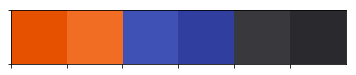

In [52]:
#spoof_mail = ["#2a2a2e", "#38383d", "#303f9f", "#3f51b5", "#f26d24", "#e65100"]
spoof_mail = ["#e65100", "#f26d24", "#3f51b5", "#303f9f", "#38383d", "#2a2a2e"]
sns.palplot(sns.color_palette(spoof_mail))

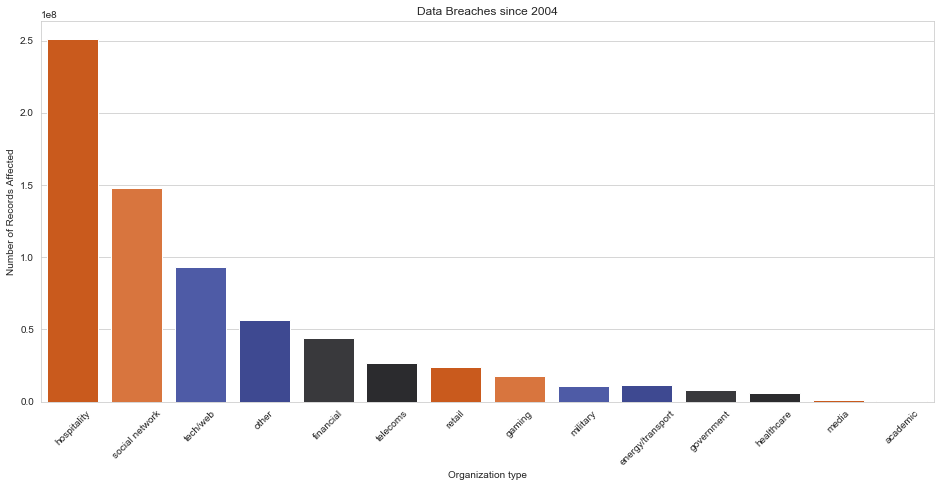

In [53]:
order=["hospitality", "social network", "tech/web", "other", "financial", "telecoms", "retail", 
       "gaming", "military", "energy/transport", "government", "healthcare", "media", "academic"]

plt.figure(figsize=(16, 7))
sns.set_style("whitegrid")
sns.despine(left=True)
sns.barplot(x="Organization type", 
            y="Records", 
            ci=None, 
            palette=spoof_mail, 
            order=order, 
            data=breach_df).set_title("Data Breaches since 2004")
plt.ylabel("Number of Records Affected")
#sns.set(font_scale=1.5)
plt.xticks(rotation=45);
#plt.savefig('data_breach.jpg')

In [ ]:
pip install plotly

In [ ]:
pip install jupyterlab==1.0 "ipywidgets>=7.5"

In [125]:
# color scheme ["#e65100", "#f26d24", "#3f51b5", "#303f9f", "#38383d", "#2a2a2e"]
import plotly.graph_objects as go
Year=[2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]

fig = go.Figure(data=[
    go.Bar(name='Healthcare', marker=dict(color="#515f72"), x=Year, y=[healthcare_09, healthcare_10, healthcare_11, healthcare_12, healthcare_13, healthcare_14, healthcare_15, healthcare_16, healthcare_17, healthcare_18, healthcare_19]),
    go.Bar(name='Financial', marker=dict(color="#f26d24"), x=Year, y=[financial_09, financial_10, financial_11, financial_12, financial_13, financial_14, financial_15, financial_16, financial_17, financial_18, financial_19]),
    go.Bar(name='Government', marker=dict(color="#e65100"), x=Year, y=[gov_09, gov_10, gov_11, gov_12, gov_13, gov_14, gov_15, gov_16, gov_17, gov_18, gov_19]),
    go.Bar(name='Retail', marker=dict(color="#303f9f"), x=Year, y=[retail_09, retail_10, retail_11, retail_12, retail_13, retail_14, retail_15, retail_16, retail_17, retail_18, retail_19]),
    go.Bar(name='Telecom', marker=dict(color="#38383d"), x=Year, y=[tel_09, tel_10, tel_11, tel_12, tel_13, tel_14, tel_15, tel_16, tel_17, tel_18, tel_19]),
    go.Bar(name='Gaming', marker=dict(color="#2a2a2e"), x=Year, y=[game_09, game_10, game_11, game_12, game_13, game_14, game_15, game_16, game_17, game_18, game_19]),
    go.Bar(name='Hospitality', marker=dict(color="#e5883a"), x=Year, y=[hos_09, hos_10, hos_11, hos_12, hos_13, hos_14, hos_15, hos_16, hos_17, hos_18, hos_19]),
    go.Bar(name='Social Networks', marker=dict(color="#3964d6"), x=Year, y=[soc_09, soc_10, soc_11, soc_12, soc_13, soc_14, soc_15, soc_16, soc_17, soc_18, soc_19]),
    go.Bar(name='Miscellaneous', marker=dict(color="#92969f"), x=Year, y=[misc_09, misc_10, misc_11, misc_12, misc_13, misc_14, misc_15, misc_16, misc_17, misc_18, misc_19]),
    go.Bar(name='Tech/Web', marker=dict(color="#7897ee"), x=Year, y=[tech_09, tech_10, tech_11, tech_12, tech_13, tech_14, tech_15, tech_16, tech_17, tech_18, tech_19])
])
fig.update_xaxes(tickvals=Year)
# Change the bar mode
fig.update_layout(barmode='stack', title=go.layout.Title(
        text="Data Breaches In The Past Decade"),
                  yaxis=go.layout.YAxis(
        title=go.layout.yaxis.Title(
            text="Number of Records Affected",
            font=dict(
                family="Courier New, monospace",
                size=18,
                color="#7f7f7f"
            )
        )
    ))
fig.write_html('first_figure.html', auto_open=True)#e65100


In [77]:
healthcare_09 = breach_df["Records"].where((breach_df["Organization type"] == 'healthcare') & (breach_df["Year"] == 2009)).sum()
healthcare_10 = breach_df["Records"].where((breach_df["Organization type"] == 'healthcare') & (breach_df["Year"] == 2010)).sum()
healthcare_11 = breach_df["Records"].where((breach_df["Organization type"] == 'healthcare') & (breach_df["Year"] == 2011)).sum()
healthcare_12 = breach_df["Records"].where((breach_df["Organization type"] == 'healthcare') & (breach_df["Year"] == 2012)).sum()
healthcare_13 = breach_df["Records"].where((breach_df["Organization type"] == 'healthcare') & (breach_df["Year"] == 2013)).sum()
healthcare_14 = breach_df["Records"].where((breach_df["Organization type"] == 'healthcare') & (breach_df["Year"] == 2014)).sum()
healthcare_15 = breach_df["Records"].where((breach_df["Organization type"] == 'healthcare') & (breach_df["Year"] == 2015)).sum()
healthcare_16 = breach_df["Records"].where((breach_df["Organization type"] == 'healthcare') & (breach_df["Year"] == 2016)).sum()
healthcare_17 = breach_df["Records"].where((breach_df["Organization type"] == 'healthcare') & (breach_df["Year"] == 2017)).sum()
healthcare_18 = breach_df["Records"].where((breach_df["Organization type"] == 'healthcare') & (breach_df["Year"] == 2018)).sum()
healthcare_19 = breach_df["Records"].where((breach_df["Organization type"] == 'healthcare') & (breach_df["Year"] == 2019)).sum()

In [85]:
tech_09 = breach_df["Records"].where((breach_df["Organization type"] == 'tech/web') & (breach_df["Year"] == 2009)).sum()
tech_10 = breach_df["Records"].where((breach_df["Organization type"] == 'tech/web') & (breach_df["Year"] == 2010)).sum()
tech_11 = breach_df["Records"].where((breach_df["Organization type"] == 'tech/web') & (breach_df["Year"] == 2011)).sum()
tech_12 = breach_df["Records"].where((breach_df["Organization type"] == 'tech/web') & (breach_df["Year"] == 2012)).sum()
tech_13 = breach_df["Records"].where((breach_df["Organization type"] == 'tech/web') & (breach_df["Year"] == 2013)).sum()
tech_14 = breach_df["Records"].where((breach_df["Organization type"] == 'tech/web') & (breach_df["Year"] == 2014)).sum()
tech_15 = breach_df["Records"].where((breach_df["Organization type"] == 'tech/web') & (breach_df["Year"] == 2015)).sum()
tech_16 = breach_df["Records"].where((breach_df["Organization type"] == 'tech/web') & (breach_df["Year"] == 2016)).sum()
tech_17 = breach_df["Records"].where((breach_df["Organization type"] == 'tech/web') & (breach_df["Year"] == 2017)).sum()
tech_18 = breach_df["Records"].where((breach_df["Organization type"] == 'tech/web') & (breach_df["Year"] == 2018)).sum()
tech_19 = breach_df["Records"].where((breach_df["Organization type"] == 'tech/web') & (breach_df["Year"] == 2019)).sum()

In [90]:
financial_09 = breach_df["Records"].where((breach_df["Organization type"] == 'financial') & (breach_df["Year"] == 2009)).sum()
financial_10 = breach_df["Records"].where((breach_df["Organization type"] == 'financial') & (breach_df["Year"] == 2010)).sum()
financial_11 = breach_df["Records"].where((breach_df["Organization type"] == 'financial') & (breach_df["Year"] == 2011)).sum()
financial_12 = breach_df["Records"].where((breach_df["Organization type"] == 'financial') & (breach_df["Year"] == 2012)).sum()
financial_13 = breach_df["Records"].where((breach_df["Organization type"] == 'financial') & (breach_df["Year"] == 2013)).sum()
financial_14 = breach_df["Records"].where((breach_df["Organization type"] == 'financial') & (breach_df["Year"] == 2014)).sum()
financial_15 = breach_df["Records"].where((breach_df["Organization type"] == 'financial') & (breach_df["Year"] == 2015)).sum()
financial_16 = breach_df["Records"].where((breach_df["Organization type"] == 'financial') & (breach_df["Year"] == 2016)).sum()
financial_17 = breach_df["Records"].where((breach_df["Organization type"] == 'financial') & (breach_df["Year"] == 2017)).sum()
financial_18 = breach_df["Records"].where((breach_df["Organization type"] == 'financial') & (breach_df["Year"] == 2018)).sum()
financial_19 = breach_df["Records"].where((breach_df["Organization type"] == 'financial') & (breach_df["Year"] == 2019)).sum()

In [92]:
gov_09 = breach_df["Records"].where((breach_df["Organization type"] == 'government') & (breach_df["Year"] == 2009)).sum()
gov_10 = breach_df["Records"].where((breach_df["Organization type"] == 'government') & (breach_df["Year"] == 2010)).sum()
gov_11 = breach_df["Records"].where((breach_df["Organization type"] == 'government') & (breach_df["Year"] == 2011)).sum()
gov_12 = breach_df["Records"].where((breach_df["Organization type"] == 'government') & (breach_df["Year"] == 2012)).sum()
gov_13 = breach_df["Records"].where((breach_df["Organization type"] == 'government') & (breach_df["Year"] == 2013)).sum()
gov_14 = breach_df["Records"].where((breach_df["Organization type"] == 'government') & (breach_df["Year"] == 2014)).sum()
gov_15 = breach_df["Records"].where((breach_df["Organization type"] == 'government') & (breach_df["Year"] == 2015)).sum()
gov_16 = breach_df["Records"].where((breach_df["Organization type"] == 'government') & (breach_df["Year"] == 2016)).sum()
gov_17 = breach_df["Records"].where((breach_df["Organization type"] == 'government') & (breach_df["Year"] == 2017)).sum()
gov_18 = breach_df["Records"].where((breach_df["Organization type"] == 'government') & (breach_df["Year"] == 2018)).sum()
gov_19 = breach_df["Records"].where((breach_df["Organization type"] == 'government') & (breach_df["Year"] == 2019)).sum()

In [95]:
retail_09 = breach_df["Records"].where((breach_df["Organization type"] == 'retail') & (breach_df["Year"] == 2009)).sum()
retail_10 = breach_df["Records"].where((breach_df["Organization type"] == 'retail') & (breach_df["Year"] == 2010)).sum()
retail_11 = breach_df["Records"].where((breach_df["Organization type"] == 'retail') & (breach_df["Year"] == 2011)).sum()
retail_12 = breach_df["Records"].where((breach_df["Organization type"] == 'retail') & (breach_df["Year"] == 2012)).sum()
retail_13 = breach_df["Records"].where((breach_df["Organization type"] == 'retail') & (breach_df["Year"] == 2013)).sum()
retail_14 = breach_df["Records"].where((breach_df["Organization type"] == 'retail') & (breach_df["Year"] == 2014)).sum()
retail_15 = breach_df["Records"].where((breach_df["Organization type"] == 'retail') & (breach_df["Year"] == 2015)).sum()
retail_16 = breach_df["Records"].where((breach_df["Organization type"] == 'retail') & (breach_df["Year"] == 2016)).sum()
retail_17 = breach_df["Records"].where((breach_df["Organization type"] == 'retail') & (breach_df["Year"] == 2017)).sum()
retail_18 = breach_df["Records"].where((breach_df["Organization type"] == 'retail') & (breach_df["Year"] == 2018)).sum()
retail_19 = breach_df["Records"].where((breach_df["Organization type"] == 'retail') & (breach_df["Year"] == 2019)).sum()

In [97]:
tel_09 = breach_df["Records"].where((breach_df["Organization type"] == 'telecoms') & (breach_df["Year"] == 2009)).sum()
tel_10 = breach_df["Records"].where((breach_df["Organization type"] == 'telecoms') & (breach_df["Year"] == 2010)).sum()
tel_11 = breach_df["Records"].where((breach_df["Organization type"] == 'telecoms') & (breach_df["Year"] == 2011)).sum()
tel_12 = breach_df["Records"].where((breach_df["Organization type"] == 'telecoms') & (breach_df["Year"] == 2012)).sum()
tel_13 = breach_df["Records"].where((breach_df["Organization type"] == 'telecoms') & (breach_df["Year"] == 2013)).sum()
tel_14 = breach_df["Records"].where((breach_df["Organization type"] == 'telecoms') & (breach_df["Year"] == 2014)).sum()
tel_15 = breach_df["Records"].where((breach_df["Organization type"] == 'telecoms') & (breach_df["Year"] == 2015)).sum()
tel_16 = breach_df["Records"].where((breach_df["Organization type"] == 'telecoms') & (breach_df["Year"] == 2016)).sum()
tel_17 = breach_df["Records"].where((breach_df["Organization type"] == 'telecoms') & (breach_df["Year"] == 2017)).sum()
tel_18 = breach_df["Records"].where((breach_df["Organization type"] == 'telecoms') & (breach_df["Year"] == 2018)).sum()
tel_19 = breach_df["Records"].where((breach_df["Organization type"] == 'telecoms') & (breach_df["Year"] == 2019)).sum()

In [99]:
game_09 = breach_df["Records"].where((breach_df["Organization type"] == 'gaming') & (breach_df["Year"] == 2009)).sum()
game_10 = breach_df["Records"].where((breach_df["Organization type"] == 'gaming') & (breach_df["Year"] == 2010)).sum()
game_11 = breach_df["Records"].where((breach_df["Organization type"] == 'gaming') & (breach_df["Year"] == 2011)).sum()
game_12 = breach_df["Records"].where((breach_df["Organization type"] == 'gaming') & (breach_df["Year"] == 2012)).sum()
game_13 = breach_df["Records"].where((breach_df["Organization type"] == 'gaming') & (breach_df["Year"] == 2013)).sum()
game_14 = breach_df["Records"].where((breach_df["Organization type"] == 'gaming') & (breach_df["Year"] == 2014)).sum()
game_15 = breach_df["Records"].where((breach_df["Organization type"] == 'gaming') & (breach_df["Year"] == 2015)).sum()
game_16 = breach_df["Records"].where((breach_df["Organization type"] == 'gaming') & (breach_df["Year"] == 2016)).sum()
game_17 = breach_df["Records"].where((breach_df["Organization type"] == 'gaming') & (breach_df["Year"] == 2017)).sum()
game_18 = breach_df["Records"].where((breach_df["Organization type"] == 'gaming') & (breach_df["Year"] == 2018)).sum()
game_19 = breach_df["Records"].where((breach_df["Organization type"] == 'gaming') & (breach_df["Year"] == 2019)).sum()

In [101]:
hos_09 = breach_df["Records"].where((breach_df["Organization type"] == 'hospitality') & (breach_df["Year"] == 2009)).sum()
hos_10 = breach_df["Records"].where((breach_df["Organization type"] == 'hospitality') & (breach_df["Year"] == 2010)).sum()
hos_11 = breach_df["Records"].where((breach_df["Organization type"] == 'hospitality') & (breach_df["Year"] == 2011)).sum()
hos_12 = breach_df["Records"].where((breach_df["Organization type"] == 'hospitality') & (breach_df["Year"] == 2012)).sum()
hos_13 = breach_df["Records"].where((breach_df["Organization type"] == 'hospitality') & (breach_df["Year"] == 2013)).sum()
hos_14 = breach_df["Records"].where((breach_df["Organization type"] == 'hospitality') & (breach_df["Year"] == 2014)).sum()
hos_15 = breach_df["Records"].where((breach_df["Organization type"] == 'hospitality') & (breach_df["Year"] == 2015)).sum()
hos_16 = breach_df["Records"].where((breach_df["Organization type"] == 'hospitality') & (breach_df["Year"] == 2016)).sum()
hos_17 = breach_df["Records"].where((breach_df["Organization type"] == 'hospitality') & (breach_df["Year"] == 2017)).sum()
hos_18 = breach_df["Records"].where((breach_df["Organization type"] == 'hospitality') & (breach_df["Year"] == 2018)).sum()
hos_19 = breach_df["Records"].where((breach_df["Organization type"] == 'hospitality') & (breach_df["Year"] == 2019)).sum()

In [103]:
soc_09 = breach_df["Records"].where((breach_df["Organization type"] == 'social network') & (breach_df["Year"] == 2009)).sum()
soc_10 = breach_df["Records"].where((breach_df["Organization type"] == 'social network') & (breach_df["Year"] == 2010)).sum()
soc_11 = breach_df["Records"].where((breach_df["Organization type"] == 'social network') & (breach_df["Year"] == 2011)).sum()
soc_12 = breach_df["Records"].where((breach_df["Organization type"] == 'social network') & (breach_df["Year"] == 2012)).sum()
soc_13 = breach_df["Records"].where((breach_df["Organization type"] == 'social network') & (breach_df["Year"] == 2013)).sum()
soc_14 = breach_df["Records"].where((breach_df["Organization type"] == 'social network') & (breach_df["Year"] == 2014)).sum()
soc_15 = breach_df["Records"].where((breach_df["Organization type"] == 'social network') & (breach_df["Year"] == 2015)).sum()
soc_16 = breach_df["Records"].where((breach_df["Organization type"] == 'social network') & (breach_df["Year"] == 2016)).sum()
soc_17 = breach_df["Records"].where((breach_df["Organization type"] == 'social network') & (breach_df["Year"] == 2017)).sum()
soc_18 = breach_df["Records"].where((breach_df["Organization type"] == 'social network') & (breach_df["Year"] == 2018)).sum()
soc_19 = breach_df["Records"].where((breach_df["Organization type"] == 'social network') & (breach_df["Year"] == 2019)).sum()

In [107]:
misc_09 = breach_df["Records"].where((breach_df["Organization type"] == 'other') & (breach_df["Year"] == 2009)).sum()
misc_10 = breach_df["Records"].where((breach_df["Organization type"] == 'other') & (breach_df["Year"] == 2010)).sum()
misc_11 = breach_df["Records"].where((breach_df["Organization type"] == 'other') & (breach_df["Year"] == 2011)).sum()
misc_12 = breach_df["Records"].where((breach_df["Organization type"] == 'other') & (breach_df["Year"] == 2012)).sum()
misc_13 = breach_df["Records"].where((breach_df["Organization type"] == 'other') & (breach_df["Year"] == 2013)).sum()
misc_14 = breach_df["Records"].where((breach_df["Organization type"] == 'other') & (breach_df["Year"] == 2014)).sum()
misc_15 = breach_df["Records"].where((breach_df["Organization type"] == 'other') & (breach_df["Year"] == 2015)).sum()
misc_16 = breach_df["Records"].where((breach_df["Organization type"] == 'other') & (breach_df["Year"] == 2016)).sum()
misc_17 = breach_df["Records"].where((breach_df["Organization type"] == 'other') & (breach_df["Year"] == 2017)).sum()
misc_18 = breach_df["Records"].where((breach_df["Organization type"] == 'other') & (breach_df["Year"] == 2018)).sum()
misc_19 = breach_df["Records"].where((breach_df["Organization type"] == 'other') & (breach_df["Year"] == 2019)).sum()